### 1. Load the dataset

**[1.1] Automatic reload modules**

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**[1.2] Import packages**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

**[1.3] Load the datasets**

In [17]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val   = pd.read_csv('../data/processed/X_val.csv')
X_test  = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val   = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

In [18]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 2. Feature Engineering

* Based on feature importance done in the previous experiment, the least significant features will be excluded in this experiment.

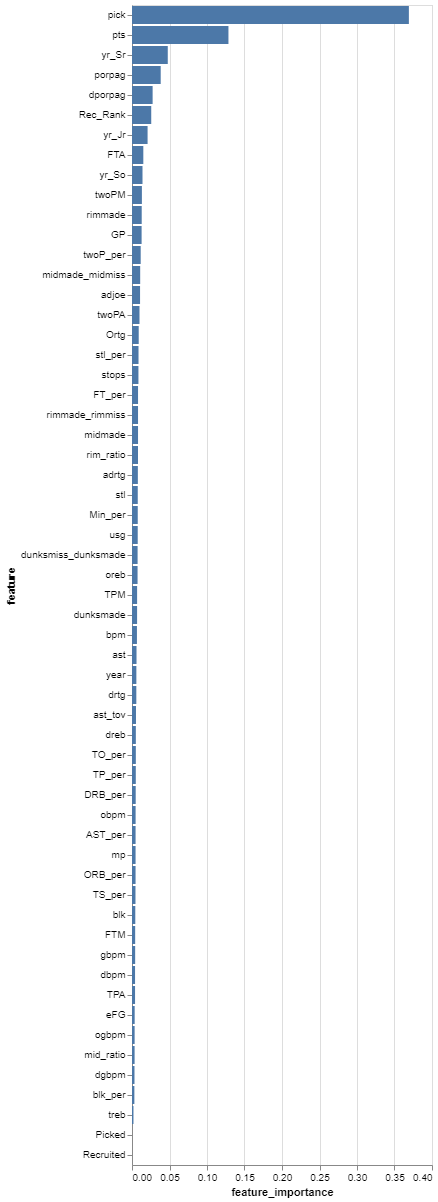

In [19]:
#list the features
X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'Picked', 'Recruited'],
      dtype='object')

In [20]:
to_drop = ['Picked', 'Recruited', 'treb']

In [22]:
X_train = X_train.drop(X_train[to_drop], axis=1)
X_val = X_val.drop(X_val[to_drop], axis=1)
X_test = X_test.drop(X_test[to_drop], axis=1)

X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'pts'],
      dtype='object')

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33001, 55)
(8251, 55)
(4970, 55)


### 3. Train XGBoost Default Model

**[3.1] Instantiate and fit the model**

In [24]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=8)

In [25]:
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=8, ...)

**[3.2] Make prediction on training data**

In [26]:
y_train_pred = xg.predict_proba(X_train)[:, 1]
y_val_pred = xg.predict_proba(X_val)[:, 1]

**[3.3] Performance metric - AUROC**

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [28]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 1.0000
Val - AUROC:
 0.9983


**Plot the AUROC curve**

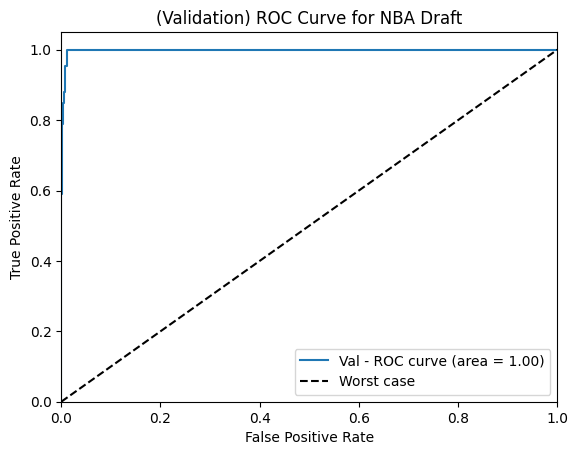

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[3.4] Predict on test data**

In [30]:
y_test_pred = xg.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week3.4.csv', index=False)

          drafted
count  4970.00000
mean      0.00449
std       0.06168
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.99987


### 4. Feature Importance

In [31]:
feature = xg.feature_importances_

In [32]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [33]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feat_imp_rf_df

,feature,feature_importance
0,pick,0.368718
1,pts,0.141849
2,yr_Sr,0.047581
3,Rec_Rank,0.028354
4,dporpag,0.027980
5,yr_Jr,0.026986
6,porpag,0.026861
7,GP,0.014683
8,twoPM,0.013232
9,FTA,0.013217


In [34]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)

**In the next experiment, hyperparameter tuning and stratified cross validation will be implemented to address overfitting issues.**